In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
import scipy.stats
import time
from useful_funcs import PAUSflux_to_ABmag
import matplotlib

matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
from astropy.cosmology import Planck15 as cosmo

cosmo = cosmo.clone(name='Planck15 H0 = 100', H0=100) #setting H0 = 100 km/s/MPc, h = 1


In [3]:
# MAY NEED ADJUSTING DEPEDNING ON DEVICE/OS RUNNING
# data = pd.read_csv("../../Data/PAUS_866.csv")
# data['band'] = data['band'].str.slice(start=2).astype(int)
# Converts 'band' column from type string to int

data = pd.read_pickle("../../Data/Object_zs_zp_181124_122626.pkl.gz")

In [4]:
data.columns

Index(['ref_id', 'zb', 'odds', 'pz_width', 'zb_mean', 'chi2', 'n_band', 'ebv',
       'qz', 'best_run',
       ...
       'band31_flux_error', 'band32_flux_error', 'band33_flux_error',
       'band34_flux_error', 'band35_flux_error', 'band36_flux_error',
       'band37_flux_error', 'band38_flux_error', 'band39_flux_error',
       'n_bands'],
      dtype='object', length=176)

In [5]:
data['type'].unique()

array([0])

# SED

In [6]:
#CUT
mask = data['conf'].astype('str').str.match('^[34]\.[0-9]$') | data['conf'].astype('str').str.match('^[29]\.5$') 

data_sample = data.loc[(data['n_bands']>=30)] #& mask & (data['zspec']!=0)]
# data_sample.shape
# data_sample['n_bands'].unique()

In [7]:
lum_dists_1d = cosmo.luminosity_distance(data_sample['zb']).value
luminosity_distances = np.repeat(lum_dists_1d[:,None],40,axis=1)
# print(luminosity_distances.shape)
# bands = data['band']
z_photos = data_sample['zb']
# object_ids = data.loc[data['zb'].notna()]['ref_id_2']
# fluxs = data.loc[data['zb'].notna()]['flux']

#GENERATE Luminosity Distances

/home/baldimort/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/baldimort/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/baldimort/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


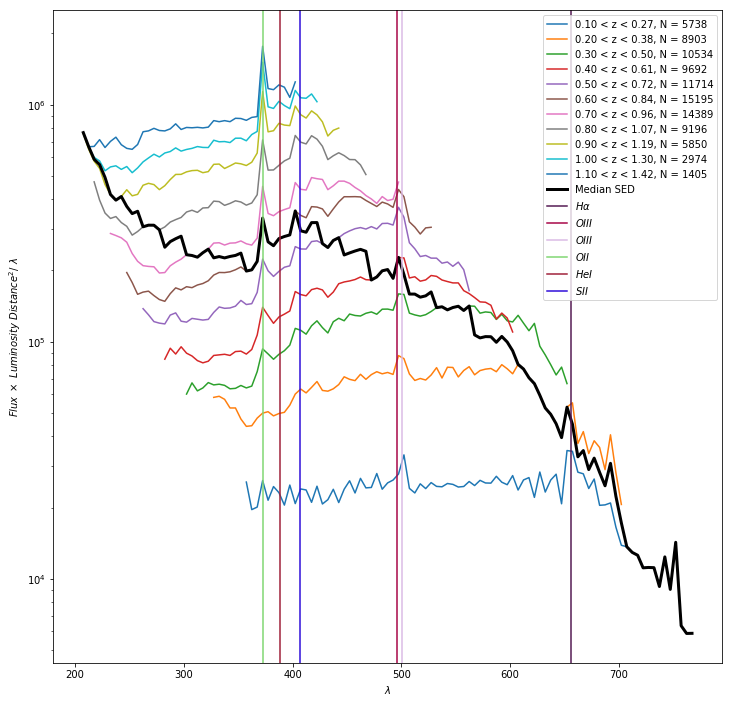

In [8]:
bins = [[0.1,0.27],[0.2,0.38],[0.3,0.5],[0.4,0.61],[0.5,0.72],[0.6,0.84],[0.7,0.96],[0.8,1.07],[0.9,1.19],[1,1.3],[1.1,1.42]]


# bins = [[0.7,0.75],[0.75,0.8],[0.8,0.85]]
fig = plt.figure(figsize=(12,12))

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)
# print(band_obsframe.min(),band_obsframe.max())
band_bins = np.arange(200,860,5)

# print(band_obsframe,band_bins)
all_means = []
# print(data.loc[(data['imag']==0)|(data['rmag']==0)|(data['odds']<0)]['flux'])


for z_bin in bins:
    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1])
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    lum_dist_sample = luminosity_distances[truth_table].flatten()
#     print(lamb_sample.shape,flux_sample.shape,lum_dist_sample.shape)
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
    binned_means = [np.nanmedian(flux_sample[digitized == i] * lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
    all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
#     print (binned_means)
    
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
             label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl

# print(np.array(all_means))
plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]
for line in emis_lines:
    random_ints = np.random.randint(256,size=3)
    plt.axvline(line[0],label=line[1],color='#{}{}{}'.\
                format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2)))

plt.xlabel(r'$\lambda$')
plt.ylabel(r'$Flux\ \times\ Luminosity\ Distance^2 /\ \lambda$')
plt.legend()
plt.yscale('log')
plt.ylim([0,2.5e6])
#plt.xlim([200,680])
plt.show()


# PAUS UV 

In [9]:
# PAUS_UV = [305,365]
# PAUS_UV_z = [0.48,1.39]

# #Z Cut
# data_sample_zcut = data_sample.loc[(data_sample['z_spec']>=PAUS_UV_z[0])&(data_sample['z_spec']<=PAUS_UV_z[1])]

# band_boundaries_ = np.arange(450,851,10)
# band_boundaries_ = np.tile(band_boundaries_,(data_sample_zcut['z_spec'].size,1))
# shifted_boundaries_ = band_boundaries_ / (1+data_sample_zcut['z_spec'].values[:,None])

# mask1 = (shifted_boundaries_[:,:-1] < PAUS_UV[0]) & (shifted_boundaries_[:,1:] > PAUS_UV[0])
# # mask1a = np.append(mask1,np.repeat(np.array([False]),mask1.shape[0])[:,None],axis=1)
# mask1a = np.insert(mask1,-1,False,axis=1)
# mask1b = np.insert(mask1,0,False,axis=1)

# mask2 = (shifted_boundaries_[:,:-1] < PAUS_UV[1]) & (shifted_boundaries_[:,1:] > PAUS_UV[1])
# mask2a = np.insert(mask2,-1,False,axis=1)
# mask2b = np.insert(mask2,0,False,axis=1)
# # print(mask1.shape,mask1a.shape,mask1b.shape,shifted_boundaries_.shape)

# mask_midvals = (shifted_boundaries_ > PAUS_UV[0]) & (shifted_boundaries_ < PAUS_UV[1]) \
# #         & (np.logical_not(mask1a)) & (np.logical_not(mask1b)) & (np.logical_not(mask2a)) &\
# #         (np.logical_not(mask2b)) 


# # fluxs = 


In [30]:

def AB_abs_mags(z_bounds,wl_bounds,data_sample,z_limits):
    """
    Function that returns the AB magnitude in a specific band and redshift cut
    
    Parameters:
    
    Input:
    1) z_bounds    - a list like object, length 2, with first entry as lower z bound, second entry as upper z bound
    2) wl_bounds   - a list like object, length 2, with first entry as lower wave length bound,
                     second entry as upper wave length bound.
    3) data_sample - Pandas dataframe with columns 'zb', 'band0' to 'band39', 'band0_flux' to 'band39_flux'
    4) z_limits     - Redshift bounds on the observation being taken
    
    Output:
    1) ABmags      - array of AB magnitudes
    
    """
    data_sample_zcut = data_sample.loc[(data_sample['zb']>=z_bounds[0])&(data_sample['zb']<=z_bounds[1])&(data_sample['zb']>z_limits[0])&(data_sample['zb']<z_limits[1])]
    if data_sample_zcut.size == 0:
        raise Exception("Input z_bounds had no data within z_limits of measurement")
    
    l_bound, r_bound = data_sample_zcut.loc[:,'band0':'band39'].values-5,data_sample_zcut.loc[:,'band0':'band39'].values+5

    # for ind,i in enumerate(data_sample_zcut['ref_id_2']):
    l_bound, r_bound = l_bound/(1+data_sample_zcut['zb'].values[:,None]),\
                        r_bound/(1+data_sample_zcut['zb'].values[:,None])

    mask_midvals = (l_bound > wl_bounds[0]) & (l_bound < wl_bounds[1]) &\
                    ((r_bound > wl_bounds[0]) & (r_bound < wl_bounds[1]))


    #Left side fraction
    mask_l = (l_bound < wl_bounds[0]) & (r_bound > wl_bounds[0])
    tmp_ls = np.where(mask_l,l_bound,np.nan)
    tmp_rs = np.where(mask_l,r_bound,np.nan)
    flux_ls = (tmp_rs - wl_bounds[0])/(tmp_rs-tmp_ls) * data_sample_zcut.loc[:,'band0_flux':'band39_flux'].values
    np.nan_to_num(flux_ls,copy=False)


    #Right side fraction
    mask_r = (l_bound < wl_bounds[1]) & (r_bound > wl_bounds[1])
    tmp_ls = np.where(mask_r,l_bound,np.nan)
    tmp_rs = np.where(mask_r,r_bound,np.nan)
    flux_rs = (tmp_rs - wl_bounds[0])/(tmp_rs-tmp_ls) * data_sample_zcut.loc[:,'band0_flux':'band39_flux'].values
    np.nan_to_num(flux_rs,copy=False)


    fluxs = np.where(mask_midvals,data_sample_zcut.loc[:,'band0_flux':'band39_flux'].values,0)
    tot_fluxs = fluxs.sum(axis=1) + flux_ls.sum(axis=1) + flux_rs.sum(axis=1)


    LDs = cosmo.luminosity_distance(data_sample_zcut['zb'])
    # print(LDs)
    ABmags = PAUSflux_to_ABmag(tot_fluxs) - 5*np.log10(LDs.value) - 25
    
    return ABmags

Bin 0.1<z<0.27 failed! Input z_bounds had no data within z_limits of measurement
Bin 0.2<z<0.38 failed! Input z_bounds had no data within z_limits of measurement
[0.3, 0.5]
[0.4, 0.61]


/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid v

[0.5, 0.72]
[0.6, 0.84]
[0.7, 0.96]
[0.8, 1.07]
[0.9, 1.19]
[1, 1.3]
[1.1, 1.42]


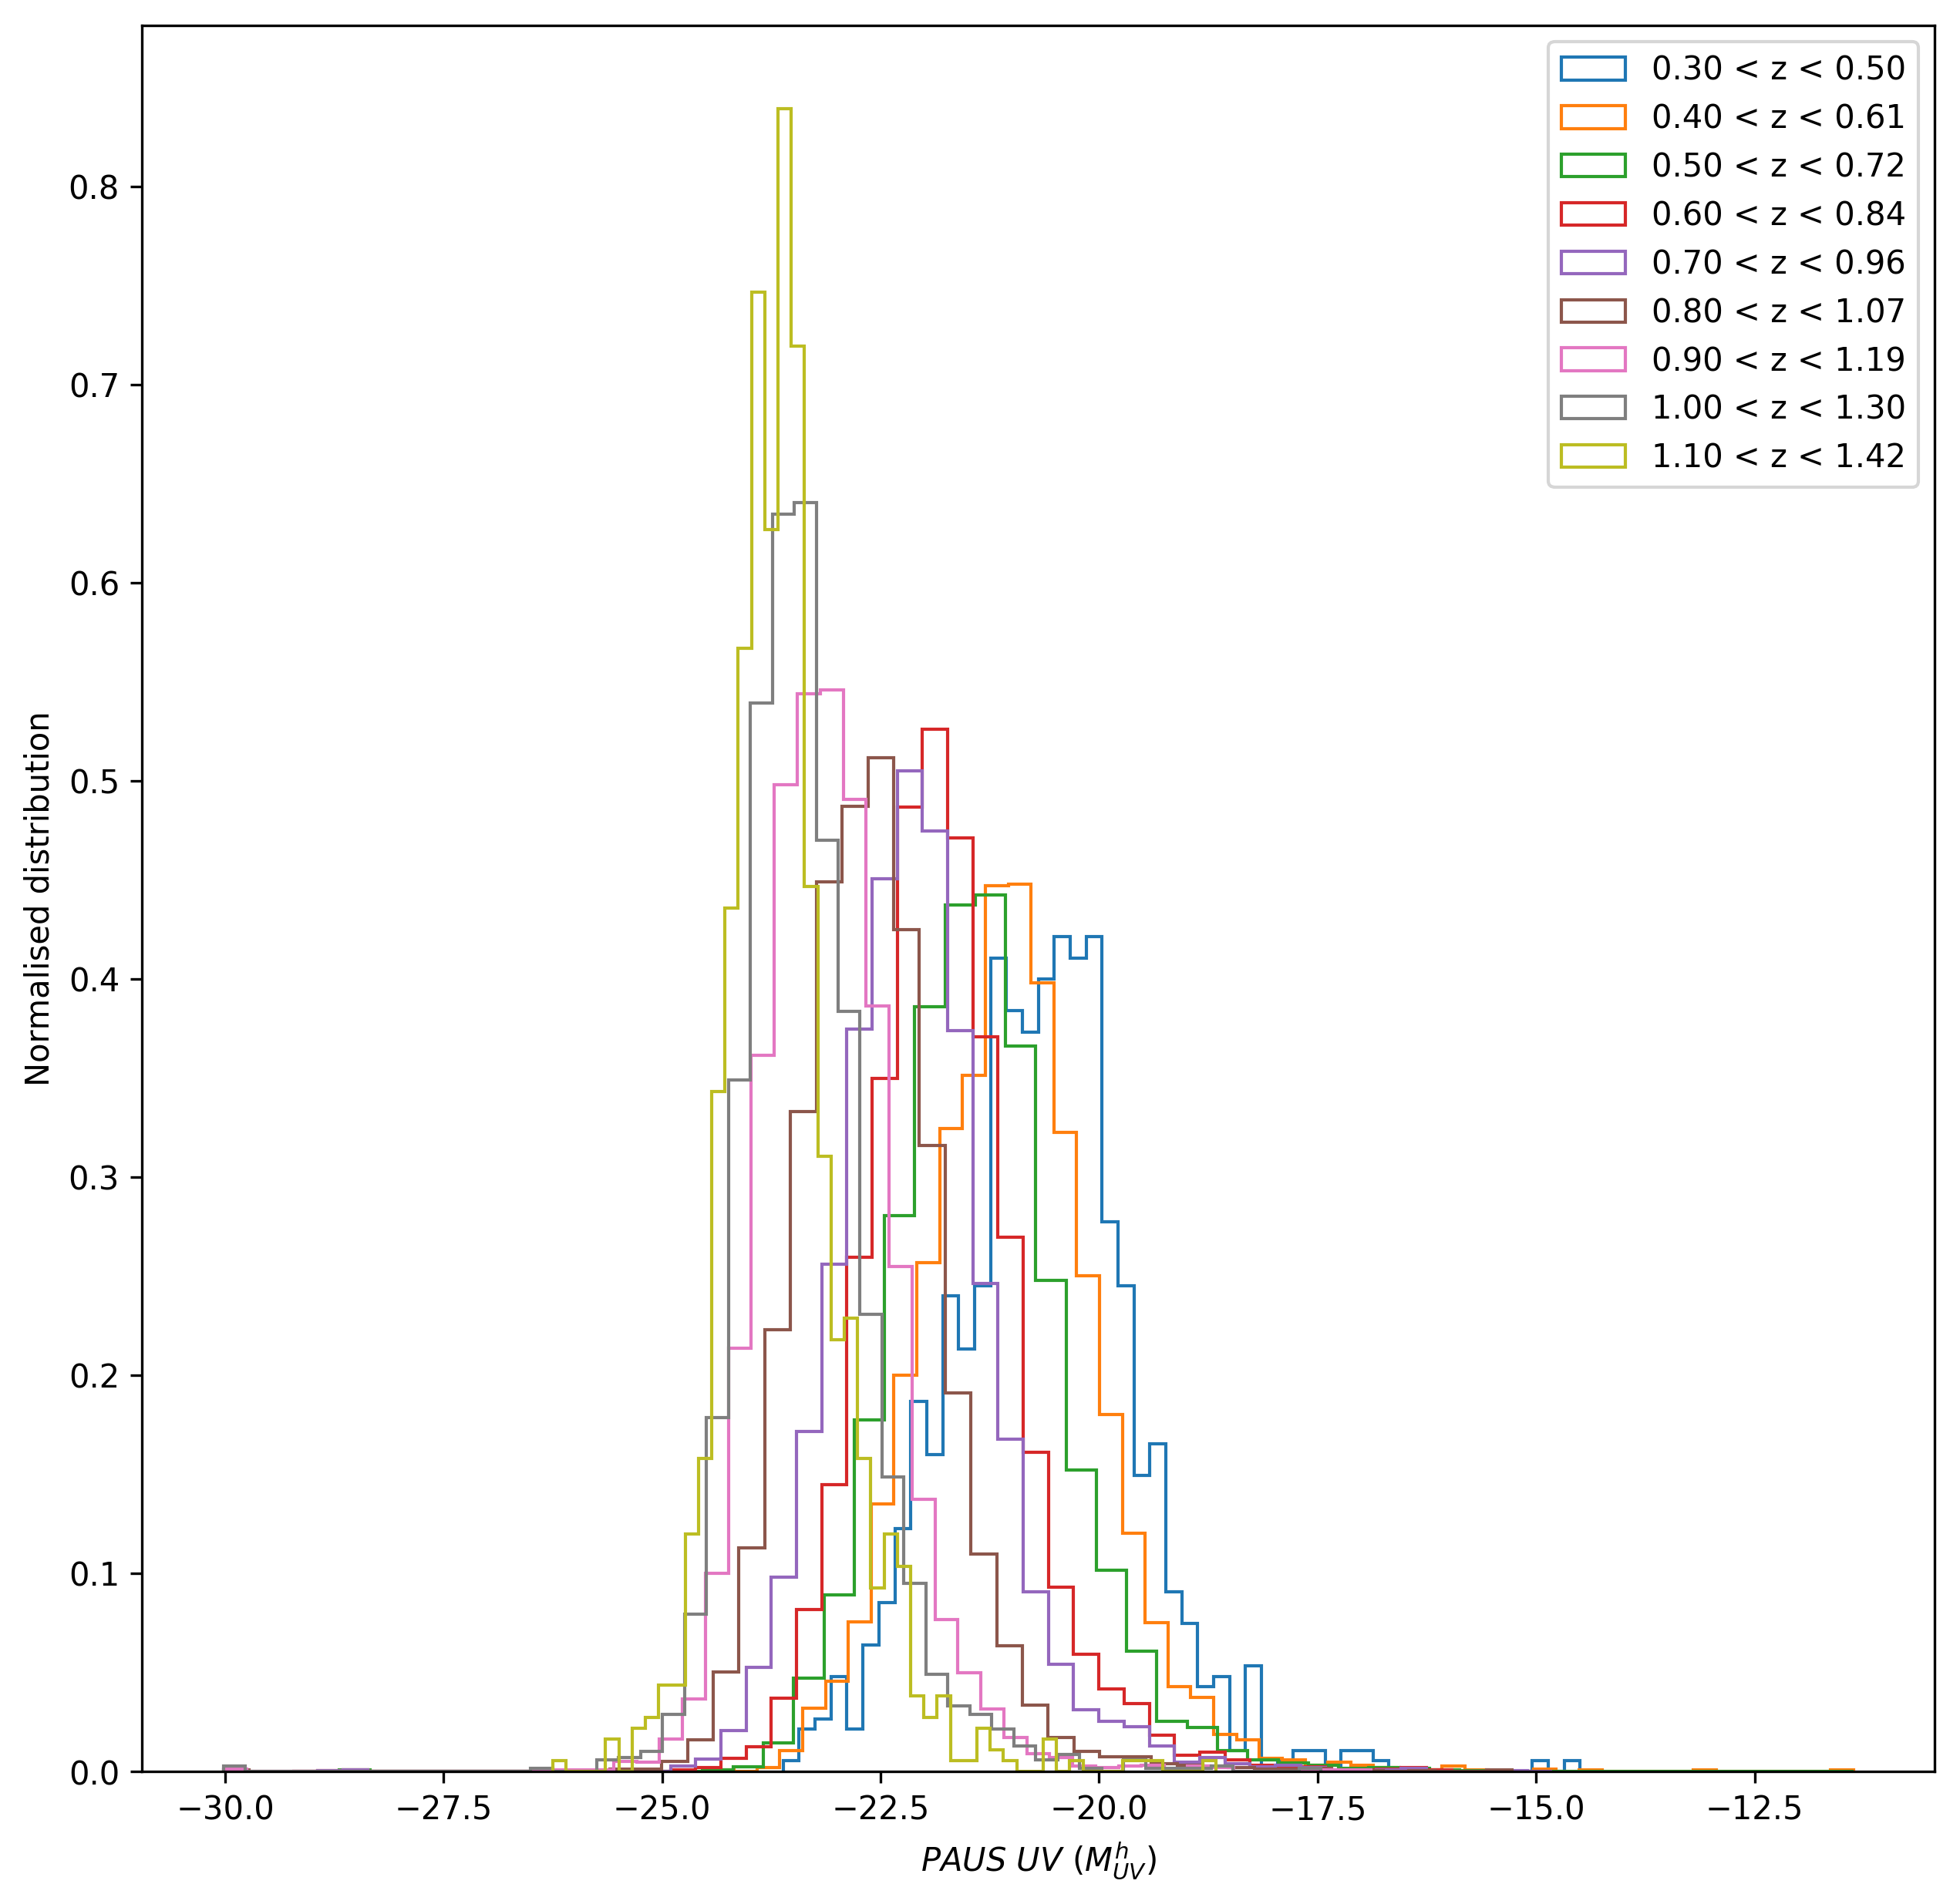

In [31]:

PAUS_UV = [305,365]
PAUS_UV_z = [0.48,1.2] #[0.48,1.39]
n = 5
zs = np.linspace(PAUS_UV_z[0],PAUS_UV_z[1],n)
PAUS_UV_zbins = []
for i in range(n-1):
    PAUS_UV_zbins.append([zs[i],zs[i+1]])


PAUS_UV_zbins = bins
    
plt.figure(figsize=(10,10),dpi=300)

UV_mags = []
for zbin in PAUS_UV_zbins:
#     print(data_sample.loc[(data_sample['zb']>zbin[0]) & (data_sample['zb']<=zbin[1])].shape)
    try:
        mags = AB_abs_mags(zbin,PAUS_UV,data_sample,PAUS_UV_z)
    except Exception as e:
        print("Bin {}<z<{} failed!".format(zbin[0],zbin[1]),e)
        continue
    print(zbin)
    UV_mags.append(mags)
    plt.hist(mags,50,histtype='step',density=True,label="{:3.2f} < z < {:3.2f}".format(zbin[0],zbin[1]))
    

plt.xlabel(r'$PAUS\ UV\ (M_{UV}^h)$')
plt.ylabel('Normalised distribution')
plt.legend()
plt.show()





# PAUS Blue

/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less
/home/baldimort/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid v

[0.1, 0.27]
[0.2, 0.38]
[0.3, 0.5]
[0.4, 0.61]
[0.5, 0.72]
[0.6, 0.84]
[0.7, 0.96]
[0.8, 1.07]
Bin 0.9<z<1.19 failed! Input z_bounds had no data within z_limits of measurement
Bin 1<z<1.3 failed! Input z_bounds had no data within z_limits of measurement
Bin 1.1<z<1.42 failed! Input z_bounds had no data within z_limits of measurement


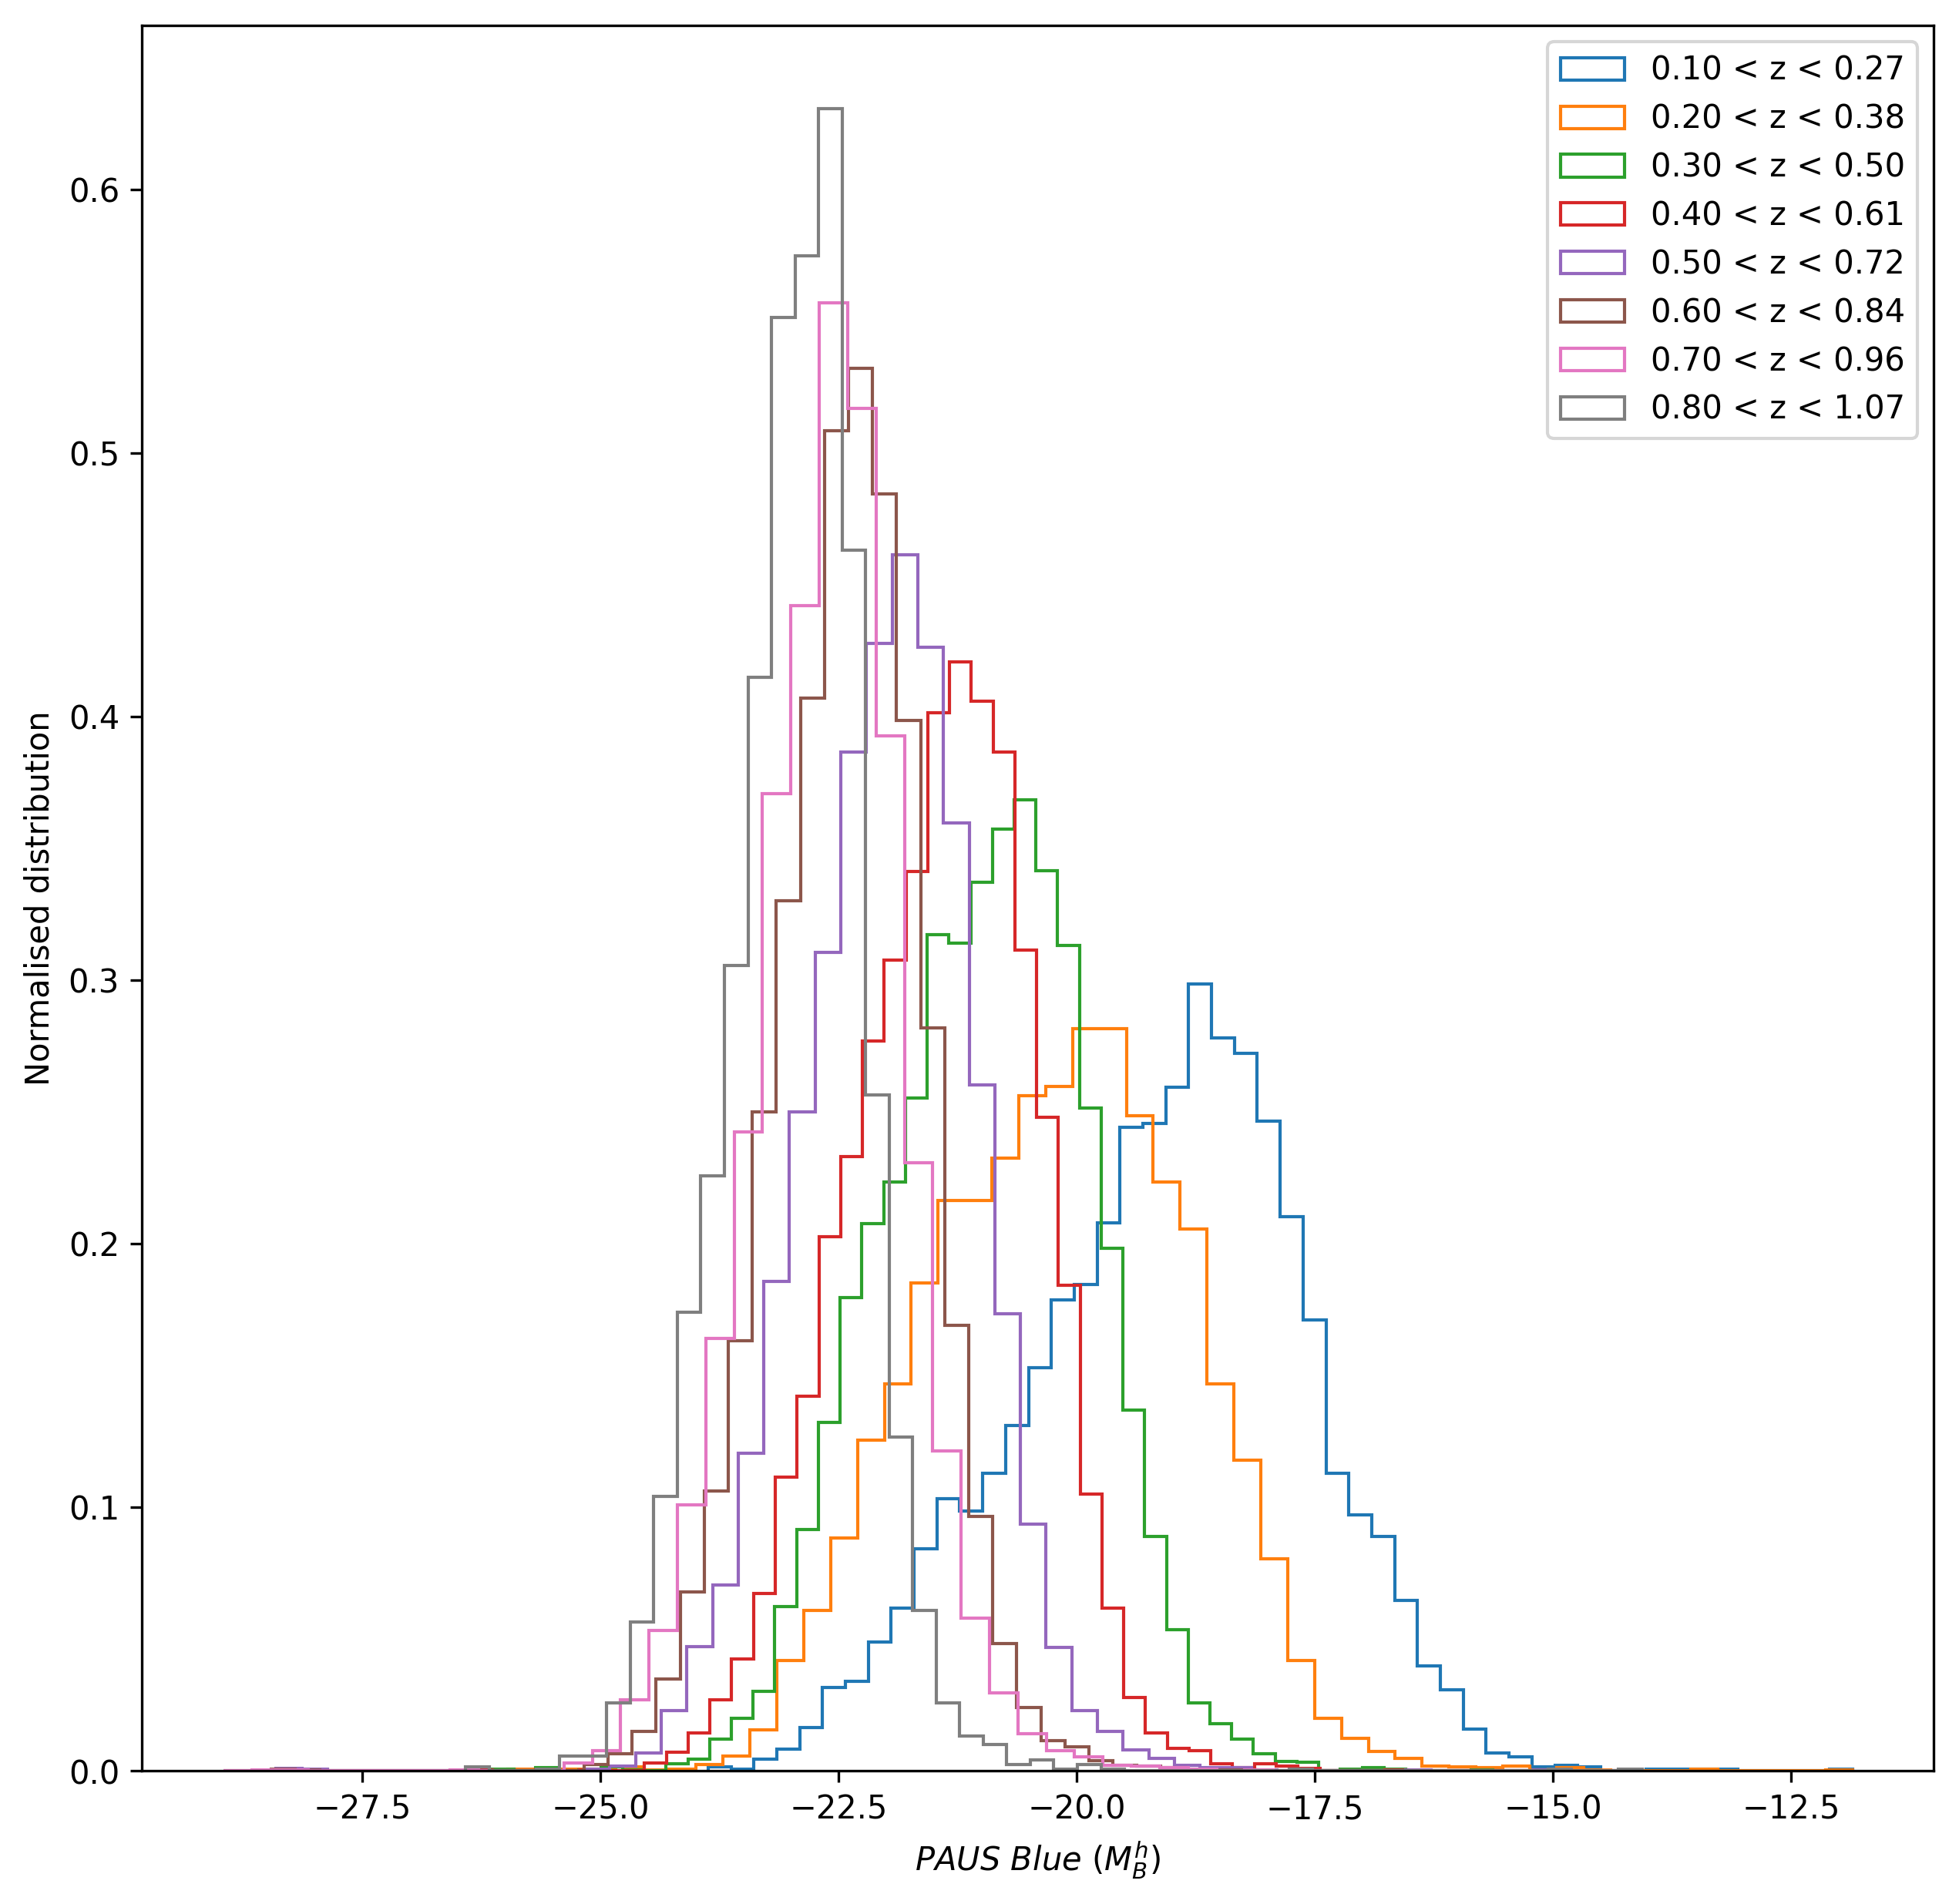

In [32]:
PAUS_blue = [405,445]
PAUS_blue_z = [0.11,0.9] #[0.48,1.39]
# n = 5
# zs = np.linspace(PAUS_blue_z[0],PAUS_blue_z[1],n)
# PAUS_UV_zbins = []
# for i in range(n-1):
#     PAUS_UV_zbins.append([zs[i],zs[i+1]])


PAUS_blue_zbins = bins
    
plt.figure(figsize=(10,10),dpi=300)

blue_mags = []
for zbin in PAUS_blue_zbins:
#     print(data_sample.loc[(data_sample['zb']>zbin[0]) & (data_sample['zb']<=zbin[1])].shape)
    try:
        mags = AB_abs_mags(zbin,PAUS_blue,data_sample,PAUS_blue_z)
    except Exception as e:
        print("Bin {}<z<{} failed!".format(zbin[0],zbin[1]),e)
        continue
    print(zbin)
    UV_mags.append(mags)
    plt.hist(mags,50,histtype='step',density=True,label="{:3.2f} < z < {:3.2f}".format(zbin[0],zbin[1]))
    

plt.xlabel(r'$PAUS\ Blue\ (M_{B}^h)$')
plt.ylabel('Normalised distribution')
plt.legend()
plt.show()


# ML Run

In [5]:
ML_DATA = pd.read_csv("../../ML runs/test_PAUS_advanced/regres/eval_nFile0/ANNZ_randomReg_0000.csv")

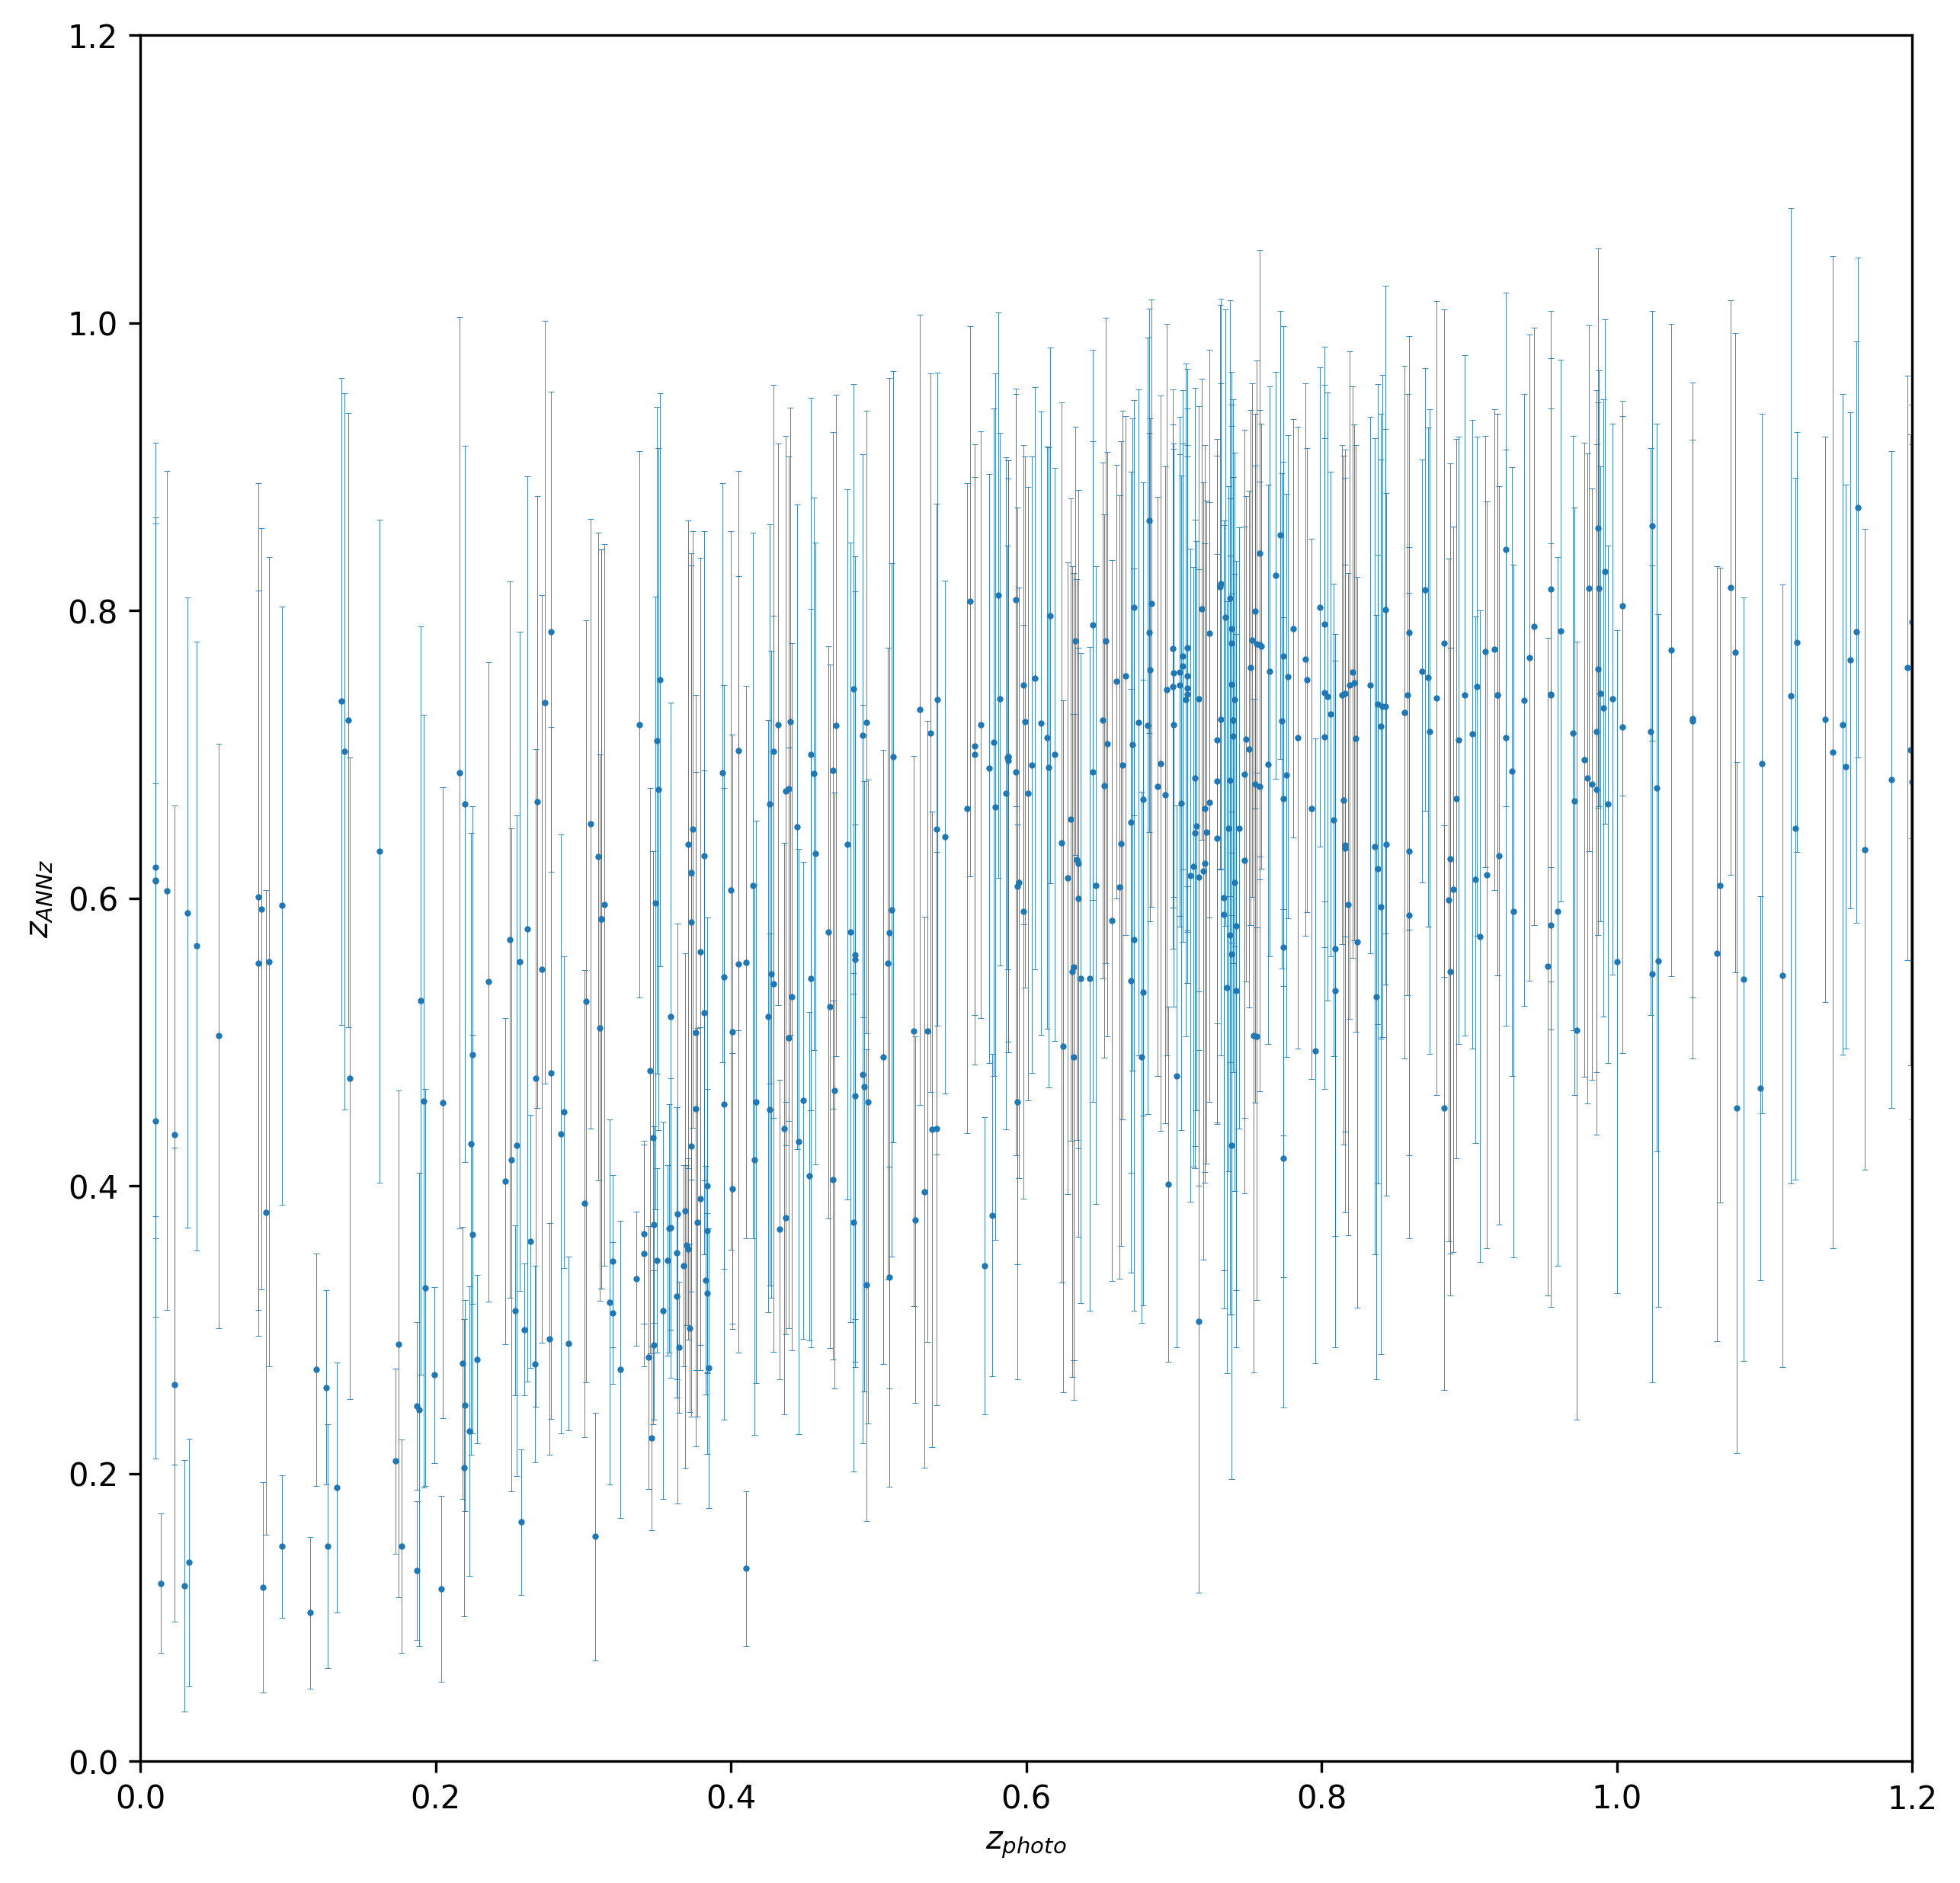

In [30]:
# ML_DATA
indices = np.random.randint(0,ML_DATA.shape[0],500)

plt.figure(figsize=(10,10),dpi=300)
plt.errorbar(ML_DATA.loc[indices,'F:Z'],ML_DATA.loc[indices,'F:ANNZ_best'],yerr=ML_DATA.loc[indices,'F:ANNZ_best_err']\
             ,fmt='o',ms=1,linewidth=0.2,capsize=1,capthick=0.2)
# plt.plot((0,1.2),(0,1.2),'k--',linewidth=1)
plt.xlabel(r'$z_{photo}$')
plt.ylabel(r'$z_{ANNz}$')
plt.xlim(0,1.2)
plt.ylim(0,1.2)

plt.show()